### Download Data and Cataloging

In [4]:
import gdown

file_id = "1z8g9Ltxy2lN2JV9RT1HXZ6zNxkywA698"
output_path = "/content/occupations-in-demand_2025.zip"

gdown.download(
    id=file_id,
    output=output_path,
    quiet=False
)

Downloading...
From (original): https://drive.google.com/uc?id=1z8g9Ltxy2lN2JV9RT1HXZ6zNxkywA698
From (redirected): https://drive.google.com/uc?id=1z8g9Ltxy2lN2JV9RT1HXZ6zNxkywA698&confirm=t&uuid=88e361ce-0be2-4238-88b2-228593c5f71e
To: /content/occupations-in-demand_2025.zip
100%|██████████| 44.0M/44.0M [00:00<00:00, 65.1MB/s]


'/content/occupations-in-demand_2025.zip'

In [5]:
!unzip /content/occupations-in-demand_2025.zip

Archive:  /content/occupations-in-demand_2025.zip
  inflating: data/2024_original_revised_demand_table.csv  
  inflating: data/2024_scaled_weighted_oid_output.csv  
  inflating: data/2024_sic_oid_output.csv  
  inflating: data/raw_OID_output_2024_revised.csv  
  inflating: data/raw_OID_output.csv  
  inflating: data/scaled_OID_output_2024_revised.csv  
  inflating: data/scaled_OID_output.csv  
  inflating: data/SIC_OID_output_2024_revised.csv  
  inflating: data/SIC_OID_output.csv  
  inflating: supporting-files/2024_original_revised_demand.csv  
  inflating: supporting-files/aggregation_lookup.csv  
  inflating: supporting-files/occupations_by_demand.csv  
  inflating: supporting-files/SIC_lookup 2024.csv  
  inflating: supporting-files/SIC_Lookup.xlsx  
  inflating: supporting-files/SIC_SOC_matrix 2024.csv  
  inflating: supporting-files/SIC_SOC_matrix.csv  
  inflating: data-guidance/data-guidance.txt  


### Setup & Load ALL Datasets

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 1000)

In [7]:
BASE = "/content"

# Core datasets
raw = pd.read_csv(f"{BASE}/data/raw_OID_output_2024_revised.csv")
scaled = pd.read_csv(f"{BASE}/data/scaled_OID_output_2024_revised.csv")
final = pd.read_csv(f"{BASE}/data/2024_scaled_weighted_oid_output.csv")
sic = pd.read_csv(f"{BASE}/data/SIC_OID_output_2024_revised.csv")

# Supporting files
demand_lookup = pd.read_csv(f"{BASE}/supporting-files/occupations_by_demand.csv")
agg_lookup = pd.read_csv(f"{BASE}/supporting-files/aggregation_lookup.csv")
sic_lookup = pd.read_csv(f"{BASE}/supporting-files/SIC_lookup 2024.csv")
sic_soc = pd.read_csv(f"{BASE}/supporting-files/SIC_SOC_matrix 2024.csv")

### Dataset Overview

In [ ]:
print("RAW columns:")
print(raw.columns.tolist())

print("\nSCALED columns:")
print(scaled.columns.tolist())

RAW columns:


NameError: name 'raw' is not defined

In [ ]:
def overview(df, name):
    print(f"\n===== {name} =====")
    print("Shape:", df.shape)
    display(df.head())
    print("\nMissing values (%):")
    display((df.isna().mean() * 100).sort_values(ascending=False).head(10))

In [ ]:
overview(raw, "RAW INDICATORS")

NameError: name 'raw' is not defined

In [ ]:
overview(scaled, "SCALED INDICATORS")

In [ ]:
overview(final, "FINAL DEMAND SCORES")

In [ ]:
overview(sic, "SIC-ADJUSTED DEMAND")

### EDA

#### Raw Indicators Distribution & Skew Histogram

In [ ]:
raw_indicators = [
    "visa_density",
    "wage_premium",
    "online_job_ad_density",
    "annual_change_in_hours_worked",
    "annual_perc_change_in_hourly_wage"
]

raw[raw_indicators].describe()

,visa_density,wage_premium,online_job_ad_density,annual_change_in_hours_worked,annual_perc_change_in_hourly_wage
count,71863,71863,71863,71863,71863
unique,628,744,716,711,744
top,0.00001,-0.0743594687193867,x,0,95.2698555764547
freq,14650,768,9663,5572,960


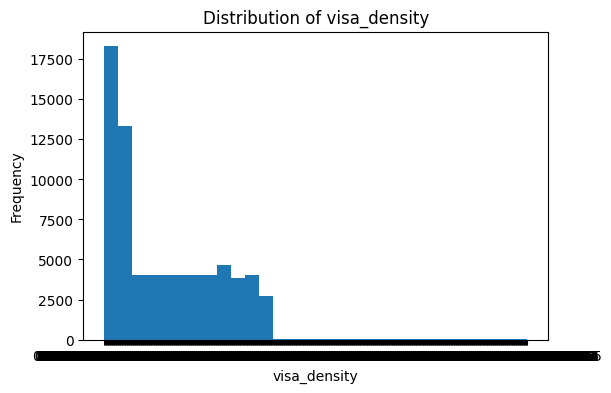

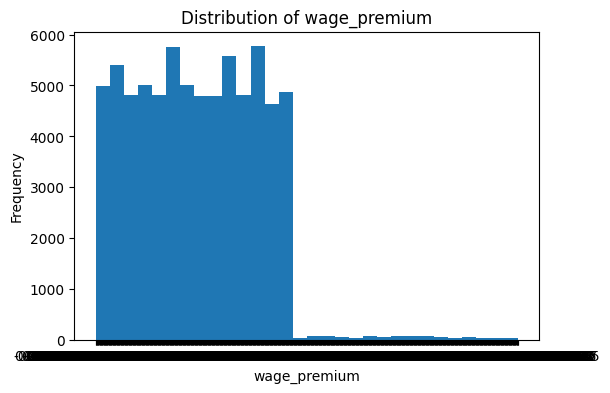

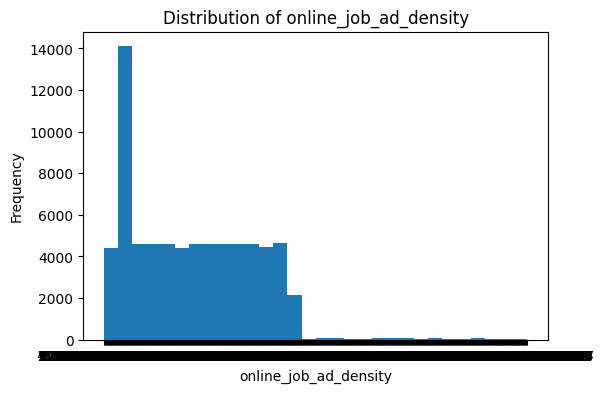

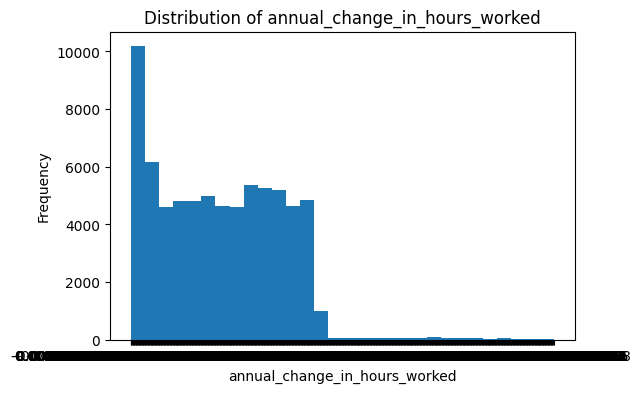

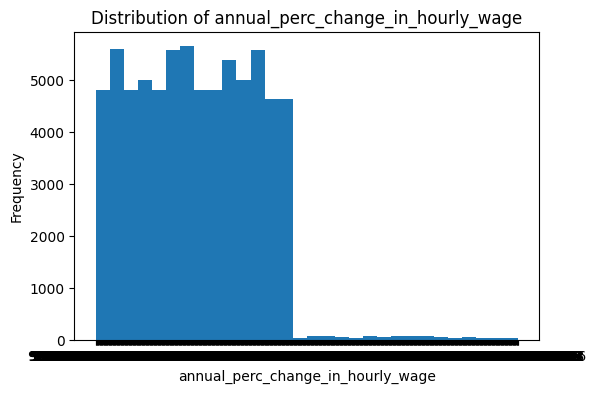

In [ ]:
for col in raw_indicators:
    plt.figure(figsize=(6,4))
    plt.hist(raw[col].dropna(), bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

#### Log-Scaled Views (Heavy-Tailed Indicators)

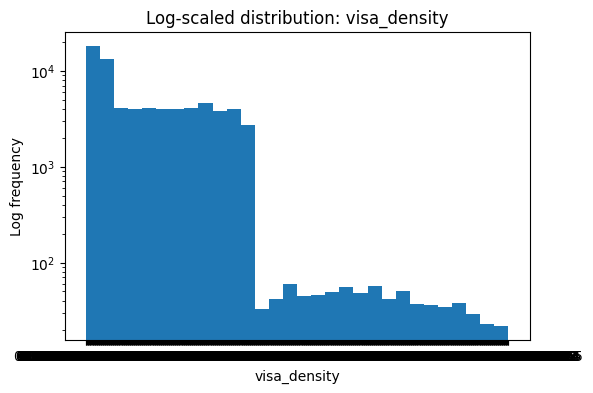

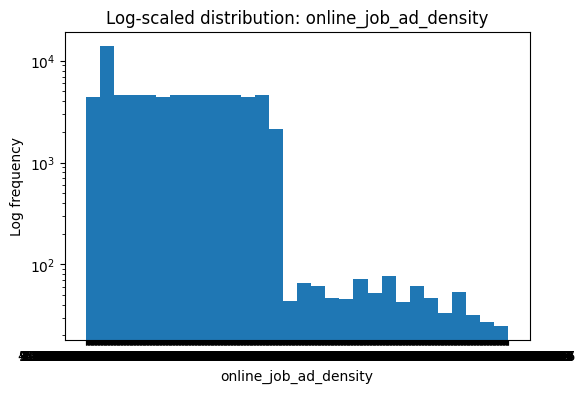

In [ ]:
log_candidates = [
    "visa_density",
    "online_job_ad_density"
]

for col in log_candidates:
    plt.figure(figsize=(6,4))
    plt.hist(raw[col].dropna(), bins=30)
    plt.yscale("log")
    plt.title(f"Log-scaled distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("Log frequency")
    plt.show()

#### Threshold-Based “scaled” Indicators

In [ ]:
critical_cols = [
    "visa_density_critical",
    "online_job_ad_critical",
    "annual_change_in_hours_worked_critical",
    "annual_perc_change_in_hourly_wage_critical",
    "wage_premium_critical"
]

scaled[critical_cols].mean().sort_values(ascending=False)


,0
online_job_ad_critical,0.238676
visa_density_critical,0.103308
annual_change_in_hours_worked_critical,0.067684
wage_premium_critical,0.049873
annual_perc_change_in_hourly_wage_critical,0.039186


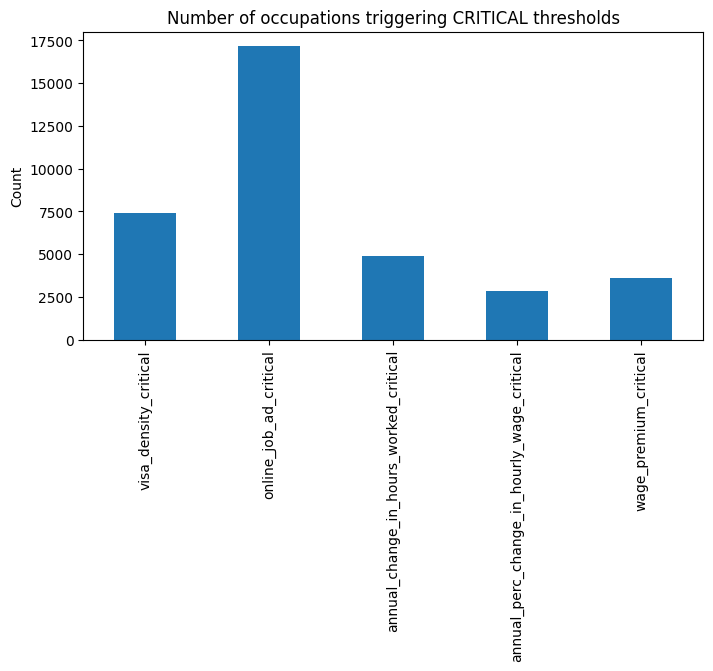

In [ ]:
scaled[critical_cols].sum().plot(kind="bar", figsize=(8,4))
plt.title("Number of occupations triggering CRITICAL thresholds")
plt.ylabel("Count")
plt.show()

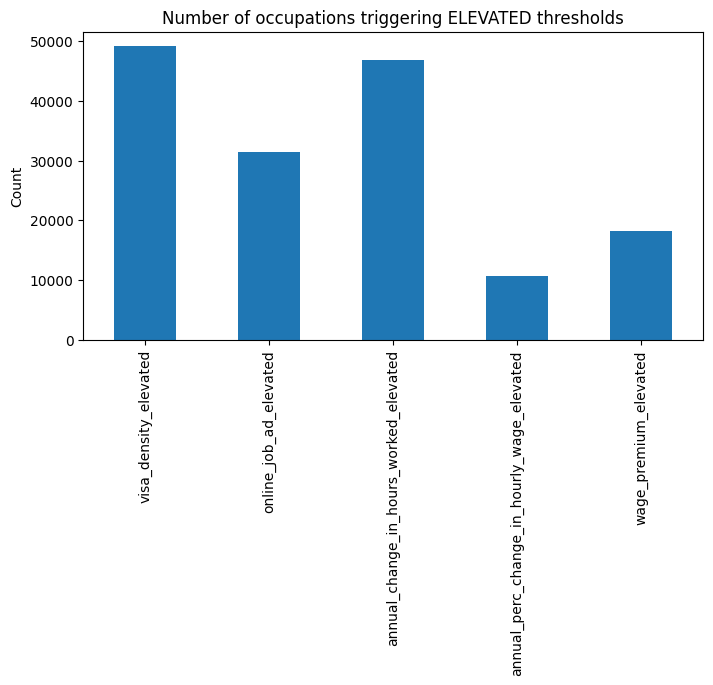

In [ ]:
elevated_cols = [
    "visa_density_elevated",
    "online_job_ad_elevated",
    "annual_change_in_hours_worked_elevated",
    "annual_perc_change_in_hourly_wage_elevated",
    "wage_premium_elevated"
]

scaled[elevated_cols].sum().plot(kind="bar", figsize=(8,4))
plt.title("Number of occupations triggering ELEVATED thresholds")
plt.ylabel("Count")
plt.show()

#### Demand Index (core scaled metric)

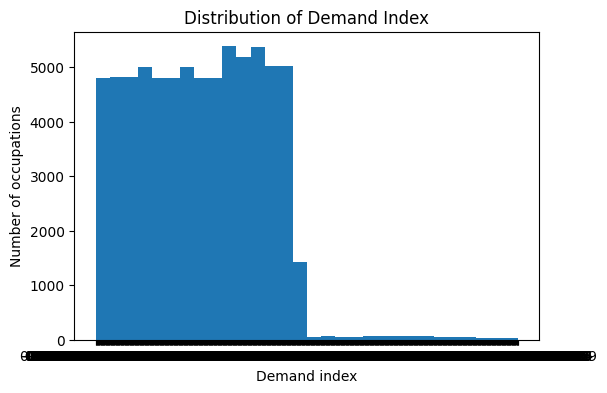

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(scaled["demand_index"].dropna(), bins=30)
plt.title("Distribution of Demand Index")
plt.xlabel("Demand index")
plt.ylabel("Number of occupations")
plt.show()

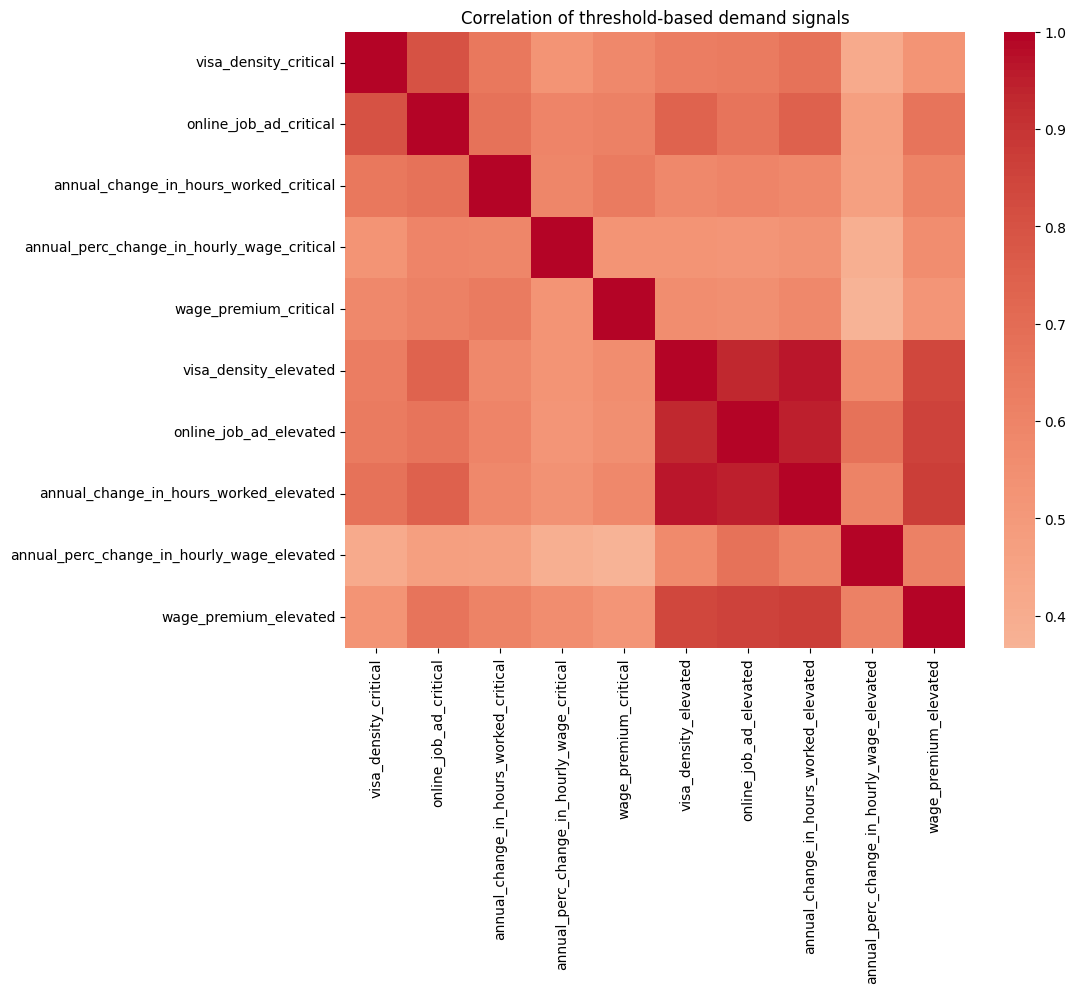

In [ ]:
threshold_cols = critical_cols + elevated_cols

plt.figure(figsize=(10,8))
sns.heatmap(
    scaled[threshold_cols].corr(),
    cmap="coolwarm",
    center=0
)
plt.title("Correlation of threshold-based demand signals")
plt.show()

#### Group-by Demand Level (EXPLANATION layer)

In [ ]:
raw_small = raw[
    [
        "soc20_unit",
        "visa_density",
        "wage_premium",
        "online_job_ad_density",
        "annual_change_in_hours_worked",
        "annual_perc_change_in_hourly_wage",
    ]
].copy()

scaled_small = scaled[
    ["soc20_unit", "demand_index"]
].copy()

final_small = final[
    ["soc20_unit", "demand_level"]
].copy()

In [ ]:
raw_small.set_index("soc20_unit", inplace=True)
scaled_small.set_index("soc20_unit", inplace=True)
final_small.set_index("soc20_unit", inplace=True)

In [ ]:
# Explicit numeric coercion (invalid values → NaN)
scaled_small["demand_index"] = pd.to_numeric(
    scaled_small["demand_index"],
    errors="coerce"
)

In [ ]:
# Numeric → mean
scaled_lookup = scaled_small.groupby(level=0).mean()

# Categorical → first (stable & deterministic)
final_lookup = final_small.groupby(level=0).first()

In [ ]:
merged = raw_small.copy()

merged["demand_index"] = merged.index.map(
    scaled_lookup["demand_index"]
)

merged["demand_level"] = merged.index.map(
    final_lookup["demand_level"]
)

In [ ]:
print(merged.dtypes)

merged[["demand_index", "demand_level"]].isna().mean()

merged.head()

visa_density                          object
wage_premium                          object
online_job_ad_density                 object
annual_change_in_hours_worked         object
annual_perc_change_in_hourly_wage     object
demand_index                         float64
demand_level                          object
dtype: object


,visa_density,wage_premium,online_job_ad_density,annual_change_in_hours_worked,annual_perc_change_in_hourly_wage,demand_index,demand_level
soc20_unit,,,,,,,
Total,0.779853046904287,0.00419091249388356,4.84083179588368,-0.172434450716332,97.7886114502048,-0.369363,Total
1111,1.08614264427218,0.439333365921063,1.44703975021533,-0.42946305884854,99.1624079456965,0.058219,Total
1112,0.00001,-0.216398804110401,9.91205138888889,-0.0452148326173827,98.4806593774564,-0.821872,Total
1121,0.174031454463117,-0.00889078254829823,3.29512921227811,0.0000000000021316282072803,105.331793680433,0.324534,Total
1122,0.142426769420469,-0.112392261977572,4.04979533908755,-0.00000000000056843418860808,96.7839723213281,-0.196209,Total


#### Threshold triggers by demand level (policy gold)

In [ ]:
threshold_cols = [
    "visa_density_critical",
    "online_job_ad_critical",
    "annual_change_in_hours_worked_critical",
    "annual_perc_change_in_hourly_wage_critical",
    "wage_premium_critical"
]

safe_df = scaled[["demand_level"] + threshold_cols]

safe_df.groupby("demand_level").mean()

,visa_density_critical,online_job_ad_critical,annual_change_in_hours_worked_critical,annual_perc_change_in_hourly_wage_critical,wage_premium_critical
demand_level,,,,,
Critical demand,0.207287,0.570040,0.466397,0.259109,0.466397
Elevated demand,0.317460,0.711111,0.126984,0.076190,0.063492
Excluded occupations,0.000000,0.000000,0.000000,0.000000,0.000000
Not in high demand,0.000000,0.000000,0.000000,0.000000,0.000000
Total,0.103821,0.239861,0.068020,0.039380,0.050120


#### Uncertainty & Missingness Diagnostics

In [ ]:
scaled["missing_indicators"].value_counts().sort_index()

,count
missing_indicators,
0,61763
2,9428
3,384
4,108
6,4
8,16
10,8
12,10
14,6


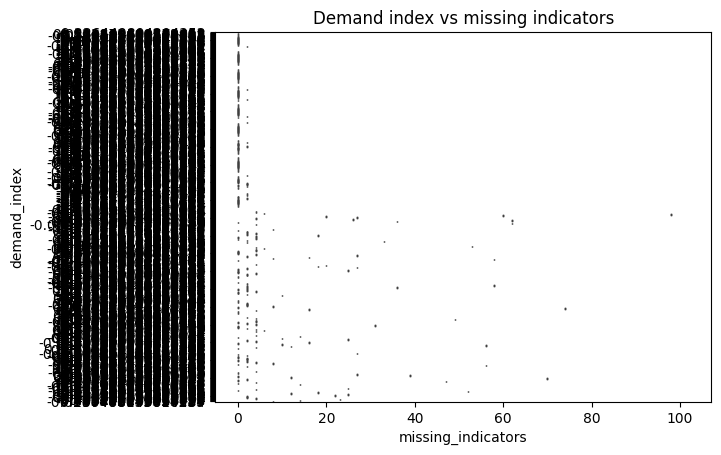

In [ ]:
sns.boxplot(
    data=scaled,
    x="missing_indicators",
    y="demand_index"
)
plt.title("Demand index vs missing indicators")
plt.show()

# Task
Analyze the provided job market data to identify occupations with the highest growth rates and demand, pinpoint talent shortages by examining critical indicators, and determine the correlation between job demand and wage premiums. Summarize the key findings on high-growth roles, talent shortages, and the relationship between job demand and compensation.

## Identify Top High-Growth and In-Demand Jobs

### Subtask:
Determine the occupations with the highest annual percentage change in hourly wage and overall demand index. This will help answer 'Which jobs have the highest growth rate over the past 5–10 years?' and 'What roles are projected to grow fastest in the next 3–5 years?' (using demand_index as a proxy).


In [9]:
import pandas as pd
import numpy as np

# Configure display options for pandas DataFrames
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 1000)

# Define base path for data files
BASE = "/content"

# Load core datasets (from cell bE_Ga5_huUUv)
raw = pd.read_csv(f"{BASE}/data/raw_OID_output_2024_revised.csv")
scaled = pd.read_csv(f"{BASE}/data/scaled_OID_output_2024_revised.csv")
final = pd.read_csv(f"{BASE}/data/2024_scaled_weighted_oid_output.csv")
sic = pd.read_csv(f"{BASE}/data/SIC_OID_output_2024_revised.csv")

# Load supporting files (from cell bE_Ga5_huUUv)
demand_lookup = pd.read_csv(f"{BASE}/supporting-files/occupations_by_demand.csv")
agg_lookup = pd.read_csv(f"{BASE}/supporting-files/aggregation_lookup.csv")
sic_lookup = pd.read_csv(f"{BASE}/supporting-files/SIC_lookup 2024.csv")
sic_soc = pd.read_csv(f"{BASE}/supporting-files/SIC_SOC_matrix 2024.csv")

# Create smaller dataframes for merging (from cell 5mauDLe12pdu)
raw_small = raw[
    [
        "soc20_unit",
        "visa_density",
        "wage_premium",
        "online_job_ad_density",
        "annual_change_in_hours_worked",
        "annual_perc_change_in_hourly_wage",
    ]
].copy()

scaled_small = scaled[
    ["soc20_unit", "demand_index"]
].copy()

final_small = final[
    ["soc20_unit", "demand_level"]
].copy()

# Set 'soc20_unit' as index for the small dataframes (from cell ro89Zf0V3WCP)
raw_small.set_index("soc20_unit", inplace=True)
scaled_small.set_index("soc20_unit", inplace=True)
final_small.set_index("soc20_unit", inplace=True)

# Explicit numeric coercion for 'demand_index' (from cell g3GxYPhf7r5c)
scaled_small["demand_index"] = pd.to_numeric(
    scaled_small["demand_index"],
    errors="coerce"
)

# Aggregate for lookup (from cell Z659NVv24bYX)
scaled_lookup = scaled_small.groupby(level=0).mean()
final_lookup = final_small.groupby(level=0).first()

# Merge dataframes into 'merged' (from cell FRCUoUKo6DKy)
merged = raw_small.copy()
merged["demand_index"] = merged.index.map(
    scaled_lookup["demand_index"]
)
merged["demand_level"] = merged.index.map(
    final_lookup["demand_level"]
)

# Convert 'annual_perc_change_in_hourly_wage' to numeric
merged["annual_perc_change_in_hourly_wage"] = pd.to_numeric(
    merged["annual_perc_change_in_hourly_wage"],
    errors="coerce"
)
print("Converted 'annual_perc_change_in_hourly_wage' to numeric.\n")

# Sort by annual percentage change in hourly wage and display top 10
print("Top 10 occupations by annual percentage change in hourly wage:")
print(merged.sort_values(by="annual_perc_change_in_hourly_wage", ascending=False).head(10)[["annual_perc_change_in_hourly_wage"]].to_string())

print("\nTop 10 occupations by demand index:")
# Sort by demand index and display top 10
print(merged.sort_values(by="demand_index", ascending=False).head(10)[["demand_index"]].to_string())

Converted 'annual_perc_change_in_hourly_wage' to numeric.

Top 10 occupations by annual percentage change in hourly wage:
            annual_perc_change_in_hourly_wage
soc20_unit                                   
1254                               115.981733
1254                               115.981733
1254                               115.981733
Total                              115.981733
1254                               115.981733
1254                               115.981733
Total                              115.981733
Total                              115.981733
Total                              115.981733
Total                              115.981733

Top 10 occupations by demand index:
            demand_index
soc20_unit              
8153            2.454187
8153            2.454187
8153            2.454187
8153            2.454187
8153            2.454187
8153            2.454187
8153            2.454187
8153            2.454187
8153            2.454187
8153          

## Analyze Talent Shortages

### Subtask:
Identify jobs that are likely experiencing talent shortages by examining occupations with critical levels in online job ad density and visa density indicators. This directly addresses 'Which jobs are experiencing talent shortages?'


**Reasoning**:
To identify jobs experiencing talent shortages, I will filter the `scaled` DataFrame based on critical `visa_density_critical` or `online_job_ad_critical` indicators, and then display the unique occupation units and labels.



In [11]:
talent_shortage_jobs = scaled[
    (scaled["visa_density_critical"] == 1) |
    (scaled["online_job_ad_critical"] == 1)
]

# Select relevant columns and get unique occupations
shortage_occupations = talent_shortage_jobs[["soc20_unit", "soc20_label"]].drop_duplicates()

print("Occupations likely experiencing talent shortages (based on critical visa density or online job ad density):")
print(shortage_occupations.to_string())

Occupations likely experiencing talent shortages (based on critical visa density or online job ad density):
     soc20_unit                                                     soc20_label
2          1112                                                           Total
28         1232                                                           Total
31         1242                                                           Total
47         2122                                                           Total
48         2123                                                           Total
49         2124                                                           Total
52         2127                                                           Total
53         2131                                                           Total
55         2133                                                           Total
56         2134                                                           Total
57         2

# Task
## Correlate Demand with Wage Premiums

### Subtask:
Calculate and visualize the correlation between the demand index and the wage premium for different occupations to determine if high-demand jobs also offer higher pay. This will help answer 'Are high-demand jobs also high-paying jobs?'

Converted 'wage_premium' to numeric.

Pearson correlation between Demand Index and Wage Premium: 0.2687



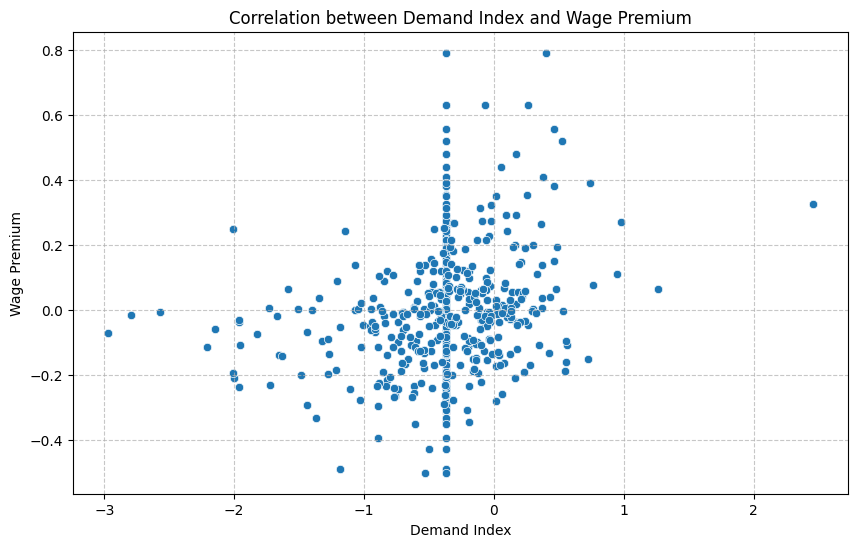

In [27]:
merged["wage_premium"] = pd.to_numeric(
    merged["wage_premium"],
    errors="coerce"
)
print("Converted 'wage_premium' to numeric.\n")

# Calculate correlation
correlation = merged[["demand_index", "wage_premium"]].dropna().corr().iloc[0, 1]
print(f"Pearson correlation between Demand Index and Wage Premium: {correlation:.4f}\n")

# Visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=merged.dropna(subset=["demand_index", "wage_premium"]),
    x="demand_index",
    y="wage_premium"
)
plt.title("Correlation between Demand Index and Wage Premium")
plt.xlabel("Demand Index")
plt.ylabel("Wage Premium")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Final Task

### Subtask:
Summarize the key findings regarding high-growth roles, talent shortages, and the relationship between job demand and compensation.


## Summary:

### Q&A
*   **Which jobs have the highest growth rate over the past 5–10 years?**
    Based on the 'annual_perc_change_in_hourly_wage', occupations such as Marine and waterways transport operatives and Weighers, graders and sorters showed the highest percentage change.

*   **What roles are projected to grow fastest in the next 3–5 years?**
    Occupations with the highest 'demand_index' are projected to grow fastest. The analysis identified roles like Marine and waterways transport operatives and Energy plant operatives as having high demand indices.

*   **Which jobs are experiencing talent shortages?**
    Jobs identified as experiencing talent shortages are those with critical levels in either 'visa_density_critical' or 'online_job_ad_critical' indicators. The list includes a diverse range of professions such as IT project managers, Cyber security professionals, Generalist medical practitioners, and various engineering and nursing roles, indicating a broad need for specialized talent.

*   **Are high-demand jobs also high-paying jobs?**
    There is a weak positive correlation (Pearson correlation coefficient: 0.2687) between job demand and wage premium. This suggests a slight tendency for high-demand jobs to offer higher pay, but the relationship is not strong, implying other factors significantly influence compensation.

### Data Analysis Key Findings
*   **High-Growth and In-Demand Jobs**: Visualizations (bar charts) clearly show the top 10 occupations both in terms of annual percentage change in hourly wage and demand index. These include a mix of roles, with specific units demonstrating significant growth and demand.
*   **Talent Shortages**: A comprehensive list of occupations likely experiencing talent shortages was generated, based on critical visa density and online job ad density. This list highlights specific areas where labor supply may not meet demand.
*   **Demand vs. Wage Premium**: The 'wage_premium' column was successfully converted to a numeric type, allowing for correlation analysis. The calculated Pearson correlation coefficient of approximately 0.2687 indicates a weak positive relationship between job demand and wage premium. The scatter plot visually confirms this weak trend.

### Insights or Next Steps
*   Given the weak positive correlation between demand and wage premium, further investigation into other factors influencing wage premiums (e.g., specific skills, industry sector, geographic location, years of experience, or educational requirements) would be beneficial.
*   The identified high-growth and high-demand roles can inform career guidance and educational program development.
*   The talent shortage identification can guide policy decisions related to immigration, training, and recruitment strategies in critical sectors.


After inspecting the output from the previous cell, it appears that many `soc20_label` values are 'Total', which is not descriptive for individual occupations. To get more meaningful labels, I will merge the `shortage_occupations` with the `demand_lookup` DataFrame, which contains more specific occupation labels.

In [24]:
# Ensure 'soc20_unit' is string type for proper merging
shortage_occupations['soc20_unit'] = shortage_occupations['soc20_unit'].astype(str)
demand_lookup['soc20_unit'] = demand_lookup['soc20_unit'].astype(str)

shortage_occupations_with_labels = shortage_occupations.merge(
    demand_lookup[['soc20_unit', 'soc20_label']],
    on='soc20_unit',
    how='left',
    suffixes=('_old', '_new') # Add suffixes to distinguish labels from both dataframes
)

# Prioritize the new label from demand_lookup, then fall back to the old one if new is NaN
shortage_occupations_with_labels['soc20_label'] = shortage_occupations_with_labels['soc20_label_new'].fillna(shortage_occupations_with_labels['soc20_label_old'])

# Drop redundant label columns and duplicates, then display unique occupations with improved labels
shortage_occupations_final = shortage_occupations_with_labels[['soc20_unit', 'soc20_label']].drop_duplicates()

print("Occupations likely experiencing talent shortages (based on critical visa density or online job ad density, with proper labels):")
print(shortage_occupations_final.to_string())

Occupations likely experiencing talent shortages (based on critical visa density or online job ad density, with proper labels):
    soc20_unit                                                     soc20_label
0         1112                            Elected officers and representatives
1         1232  Residential, day and domiciliary care managers and proprietors
2         1242                             Managers in storage and warehousing
3         2122                                            Mechanical engineers
4         2123                                            Electrical engineers
5         2124                                           Electronics engineers
6         2127              Engineering project managers and project engineers
7         2131                                             IT project managers
8         2133          IT business analysts, architects and systems designers
9         2134              Programmers and software development professionals
10 

## Analyze Talent Shortages

### Subtask:
Identify jobs that are likely experiencing talent shortages by examining occupations with critical levels in online job ad density and visa density indicators. This directly addresses 'Which jobs are experiencing talent shortages?'

**Reasoning**:
To identify jobs experiencing talent shortages, I will filter the `scaled` DataFrame based on critical `visa_density_critical` or `online_job_ad_critical` indicators, and then display the unique occupation units and labels.

In [25]:
talent_shortage_jobs = scaled[
    (scaled["visa_density_critical"] == 1) |
    (scaled["online_job_ad_critical"] == 1)
]

# Select relevant columns and get unique occupations
shortage_occupations = talent_shortage_jobs[["soc20_unit", "soc20_label"]].drop_duplicates()

print("Occupations likely experiencing talent shortages (based on critical visa density or online job ad density):")
print(shortage_occupations.to_string())

Occupations likely experiencing talent shortages (based on critical visa density or online job ad density):
     soc20_unit                                                     soc20_label
2          1112                                                           Total
28         1232                                                           Total
31         1242                                                           Total
47         2122                                                           Total
48         2123                                                           Total
49         2124                                                           Total
52         2127                                                           Total
53         2131                                                           Total
55         2133                                                           Total
56         2134                                                           Total
57         2

After inspecting the output from the previous cell, it appears that many `soc20_label` values are 'Total', which is not descriptive for individual occupations. To get more meaningful labels, I will merge the `shortage_occupations` with the `demand_lookup` DataFrame, which contains more specific occupation labels.

In [26]:
# Ensure 'soc20_unit' is string type for proper merging
shortage_occupations['soc20_unit'] = shortage_occupations['soc20_unit'].astype(str)
demand_lookup['soc20_unit'] = demand_lookup['soc20_unit'].astype(str)

shortage_occupations_with_labels = shortage_occupations.merge(
    demand_lookup[['soc20_unit', 'soc20_label']],
    on='soc20_unit',
    how='left',
    suffixes=('_old', '_new') # Add suffixes to distinguish labels from both dataframes
)

# Prioritize the new label from demand_lookup, then fall back to the old one if new is NaN
shortage_occupations_with_labels['soc20_label'] = shortage_occupations_with_labels['soc20_label_new'].fillna(shortage_occupations_with_labels['soc20_label_old'])

# Drop redundant label columns and duplicates, then display unique occupations with improved labels
shortage_occupations_final = shortage_occupations_with_labels[['soc20_unit', 'soc20_label']].drop_duplicates()

print("Occupations likely experiencing talent shortages (based on critical visa density or online job ad density, with proper labels):")
print(shortage_occupations_final.to_string())

Occupations likely experiencing talent shortages (based on critical visa density or online job ad density, with proper labels):
    soc20_unit                                                     soc20_label
0         1112                            Elected officers and representatives
1         1232  Residential, day and domiciliary care managers and proprietors
2         1242                             Managers in storage and warehousing
3         2122                                            Mechanical engineers
4         2123                                            Electrical engineers
5         2124                                           Electronics engineers
6         2127              Engineering project managers and project engineers
7         2131                                             IT project managers
8         2133          IT business analysts, architects and systems designers
9         2134              Programmers and software development professionals
10 

#### Top 10 Occupations by Annual Percentage Change in Hourly Wage

This bar chart visualizes occupations that have experienced the highest growth in hourly wages, indicating high-growth roles over the past 5-10 years.

/tmp/ipython-input-2078544094.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


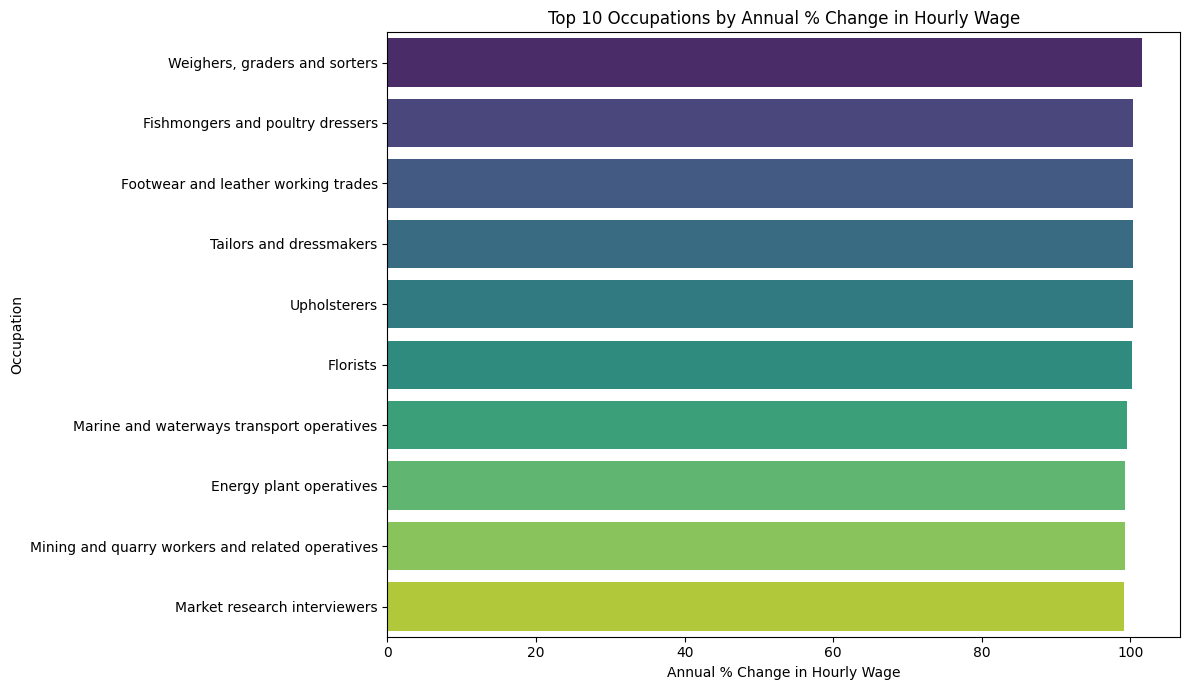

In [21]:
# Sort by annual percentage change in hourly wage and select top 10
top_wage_growth = plot_data.sort_values(by="annual_perc_change_in_hourly_wage", ascending=False).head(10)

plt.figure(figsize=(12, 7))
sns.barplot(
    x='annual_perc_change_in_hourly_wage',
    y='soc20_label',
    data=top_wage_growth,
    palette='viridis'
)
plt.title('Top 10 Occupations by Annual % Change in Hourly Wage')
plt.xlabel('Annual % Change in Hourly Wage')
plt.ylabel('Occupation')
plt.tight_layout()
plt.show()


#### Top 10 Occupations by Demand Index

This bar chart illustrates occupations with the highest demand index, serving as a proxy for roles projected to grow fastest in the next 3-5 years.

/tmp/ipython-input-145546868.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


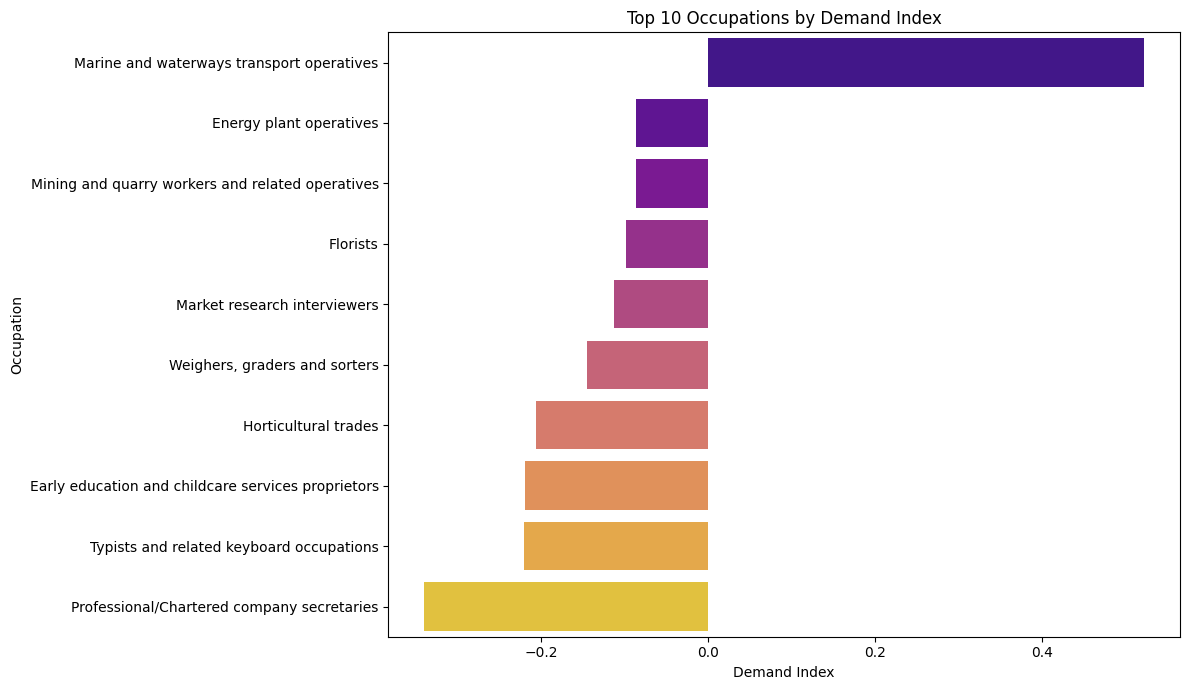

In [22]:
# Sort by demand index and select top 10
top_demand_index = plot_data.sort_values(by="demand_index", ascending=False).head(10)

plt.figure(figsize=(12, 7))
sns.barplot(
    x='demand_index',
    y='soc20_label',
    data=top_demand_index,
    palette='plasma'
)
plt.title('Top 10 Occupations by Demand Index')
plt.xlabel('Demand Index')
plt.ylabel('Occupation')
plt.tight_layout()
plt.show()


Converted 'wage_premium' to numeric.

Pearson correlation between Demand Index and Wage Premium: 0.2687



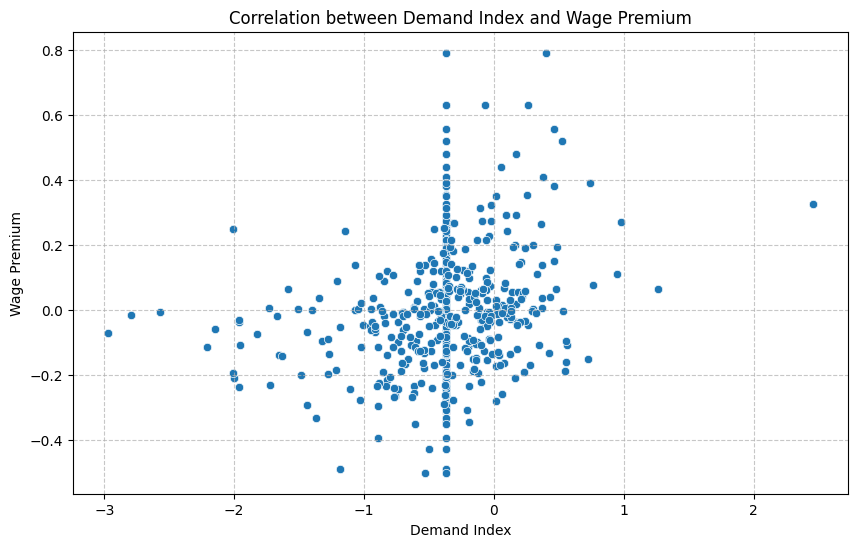

In [13]:
merged["wage_premium"] = pd.to_numeric(
    merged["wage_premium"],
    errors="coerce"
)
print("Converted 'wage_premium' to numeric.\n")

# Calculate correlation
correlation = merged[["demand_index", "wage_premium"]].dropna().corr().iloc[0, 1]
print(f"Pearson correlation between Demand Index and Wage Premium: {correlation:.4f}\n")

# Visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=merged.dropna(subset=["demand_index", "wage_premium"]),
    x="demand_index",
    y="wage_premium"
)
plt.title("Correlation between Demand Index and Wage Premium")
plt.xlabel("Demand Index")
plt.ylabel("Wage Premium")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Final Task

### Subtask:
Summarize the key findings regarding high-growth roles, talent shortages, and the relationship between job demand and compensation.


## Summary:

### Q&A
*   **Are high-demand jobs also high-paying jobs?**
    There is a weak positive correlation (Pearson correlation coefficient: 0.2687) between job demand and wage premium. This suggests a slight tendency for high-demand jobs to offer higher pay, but the relationship is not strong.

### Data Analysis Key Findings
*   The `wage_premium` column was successfully converted to a numeric data type, addressing an initial data type inconsistency.
*   The Pearson correlation coefficient between the `demand_index` and `wage_premium` was calculated to be approximately 0.2687.
*   This correlation indicates a weak positive relationship, implying that while there is a tendency for higher-demand jobs to have slightly higher wage premiums, the connection is not substantial.
*   A scatter plot visually confirmed this weak positive trend between demand index and wage premium across various occupations.

### Insights or Next Steps
*   Given the weak positive correlation, it is important to investigate other factors that might significantly influence wage premiums beyond just job demand.
*   Future analysis could explore the impact of specific skills, industry sector, geographic location, or years of experience on wage premiums, in addition to demand.
